# AIREO pilot dataset - Biomass (Forest Observation System)


Forest Observation System [FOS](https://forest-observation-system.net) is an international cooperation aiming to establish an in-situ forest biomass database in order to support Earth Observation with reliable, up to date, representative and comparable data for validation (Schepaschenko, D. et al. 2019).

## Introduction

The notebook demonstrates the use of <b> aireo_lib </b>, a python library created as a part of the [AIREO](https://aireo.net/) (Artificial Intelligence Ready Earth Observation training datasets) project. The project aims to make EO datasets easily accessible for the ML (Machine Learning) community. As such, AIREO specifications (shorthand specs) which define metadata elements to be included with the training dataset are proposed, supplemented by a best-practices document which suggests how to fill those metadata elements. Finally, the library takes all into account and implements specs, best-practices and offers an easy-to-use pythonic interface bridging the gap between EO and ML community.

Therefore, this notebook is divided into two sections, one for the training dataset creator (usually from the EO community) and the other for its user (usually from the ML community). The structure of the notebook is the following:


1) For Creator 

    - Create a [STAC](https://stacspec.org/) catalog object using the library
    
    - Populate metadata elements prescribed by the AIREO specs
    
    - Generate a STAC metadata directory using the library

    - Check AIREO compliance level and metadata completeness

   
2) For User 

    - Create a training dataset object as defined in the library using only the STAC metadata
    
    - Get example instances from the object and other dataset variables like the number of instances, etc.
    
    - Use library's functions to plot the data
    
    - Investigate statistics using the library

## AIREO STAC Catalog basics

The AIREO specs propose a hierarchical structure for STAC metadata. It is a two level structure where the dataset is represented by a collection of AOIs (Area Of Interests), hence, the dataset and AOI being the two levels.

1. At the dataset level we have a dataset catalog whose metadata elements are the core elements proposed in the AIREO spec. In addition to it, the common metadata elements across each AOI are also at the dataset level, which we shall call root level henceforth. Here, for each data variable there is a separate json which is a STAC Item by definition and is named using the field_schema metadata element. Additionally, there is also a datasheet file in markdown format at the root level which contains human readable information about the key elements of the dataset.

2. Each AOI has a separate folder within the root level. And in each AOI folder there is a STAC collection representing that AOI and additional json files for each data variable. The additional json files here too, are STAC Items and follow a similar naming convention to the ones at the root level. The assets for each AOI, i.e. the files containing actual data are also in the folder.

The diagram below summarises this hierarchical structure:


```
Root level (dataset)
│
│   DatasetCatalog.json
│   datasheet.md
│   references_output1.json
│   features_input1.json
│   ...
│
│
└───AOI 1
│      1.json (AOI Collection)
│      feature_input1.json
│      reference_output1.json
│      <reference_asset>
│      <feature_asseet>
│   
│   
└───AOI 2
│      ...
│   
│
└───AOI 3
│      ...
│   
...     
```

## Creator perpsective

In [208]:
import aireo_lib.core
import os
import json
import numpy as np
from osgeo import gdal
from tqdm.notebook import tqdm
from shapely import geometry
import shutil
import rioxarray
import xarray as xr
from pathlib import Path
from sentinelhub import (SHConfig, BBox, bbox_to_dimensions, CRS,SentinelHubBatch, SentinelHubRequest, DataCollection, MimeType, FisRequest)
from sentinelhub.geometry import Geometry
import matplotlib.pyplot as plt
import PIL.Image as Image

In [209]:
# Path to write the STAC root metadata file too
catalog_fn_w_path = './Biomass_stac_generated/EO_TDS.json'

# Creating an empty STAC Catalog object
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog()

In [210]:
# Get AOI list for the TDS

reference_path = 'Biomass_tiff/'
#print(os.listdir(reference_path))
aoi_ids = [i.replace('.tif','').replace('patch_', '') for i in os.listdir(reference_path) if '.tif' in i]
aoi_ids

['ALP-02_0_3',
 'ALP-02_0_2',
 'ASN-02_0_0',
 'ALP-02_0_0',
 'ALP-02_0_1',
 'ASN-02_0_1',
 'ALF-01_0_1',
 'BCI-01_00_4',
 'ALF-01_0_0',
 'ALF-01_0_2',
 'ALF-01_0_3',
 'AU_BEN-NR1_1',
 'ALP-01_0_0',
 'BCI-01_00_3',
 'ASN-02_1_0',
 'ASN-02_1_1',
 'BCI-01_00_2',
 'ALP-01_0_1',
 'ALP-01_0_3',
 'BCI-01_00_0',
 'BCI-01_00_1',
 'ALP-01_0_2',
 'AU_DalyRegrowth_1',
 'AU_AdelaideRiver_1',
 'ALP-30_3_0',
 'ALV-02_1_1',
 'ALP-30_1_0',
 'ALV-02_1_0',
 'AU_Remnant6-Rugby_Reserve_1',
 'ALP-30_0_0',
 'ALV-02_0_1',
 'ALV-02_0_0',
 'ALP-30_2_0']

In [211]:
# Creating root metadata dictionary

tds_root_core_metadata_d = {}
tds_root_core_metadata_d['aireo_version'] = "0.0.1-alpha.1"
tds_root_core_metadata_d['title'] = "Aireo Pilot datasets - Forest Observatory System - Biomass"
tds_root_core_metadata_d['description'] = "Above ground biomass split in 260 plots of 50 x 50 m."
tds_root_core_metadata_d['created'] = 'Null'
tds_root_core_metadata_d['license_url_list'] = 'https://creativecommons.org/licenses/by/4.0/deed.de' 
tds_root_core_metadata_d['license'] = "CC-BY-4.0"
tds_root_core_metadata_d["providers_name"]= "[FOS, RAINFOR, AfriTRON]"
tds_root_core_metadata_d["providers_description"] = "international cooperation to establish a global in-situ forest biomass database to support earth observation and to encourage investment in relevant field-based observations and science."
tds_root_core_metadata_d["providers_roles"] = {'FOS': ["licensor", "host"], 'RAINFOR':["producer", "processor" , "host"],'AfriTRON':["producer", "processor" ]}
tds_root_core_metadata_d["providers_url"]= {'FOS':'https://forest-observation-system.net', 'RAINFOR': 'https://www.rainfor.org/', 
                        'AfriTRON': 'https://www.afritron.org/'}                         
tds_root_core_metadata_d['id'] =  "aa24c994-e8a9-4175-9a16-7def23bf762b" #changed UUID
tds_root_core_metadata_d['type'] = "Collection"
tds_root_core_metadata_d['stac_version'] = '1.0.0-beta.2'
tds_root_core_metadata_d['provenance'] = 'The dataset was fed by providers based on ground field measurements (see providers) and the accompanying satellite images were provided by Sentinel Hub (see links in providers) using Sentinel 2 images.'
tds_root_core_metadata_d['purpose'] = "The dataset has sentinel 2 images matching the location of each plotID in order to add remote sensing imagery to in-situ data taken from dataset  "
tds_root_core_metadata_d['tasks'] =  ['regression']
tds_root_core_metadata_d['data_preprocessing'] = 'Only satellite images with cloud cover less than 20% are considered'
tds_root_core_metadata_d['funding_info'] = "The AIREO project is funded by ESA, the underlying fields and crop data are funded by Agricultural Market Austria and the satellite imagery used is through funds from ESA."
tds_root_core_metadata_d['field_schema'] = {'features': {'input1': ['georeferenced_eo_image']}, 'references': {'output1': ['reference_data']}}
tds_root_core_metadata_d['example_definition'] = "An example for ML training would be a satellite imagery with its biomass associated as referece. That could be used to predict Biomass measurements in other parts of the planet using regression method"

tds_root_core_metadata_d['example_window_size'] = 256 #do you need these twofor biomass? they are for sampling
tds_root_core_metadata_d['example_stride'] = 26
                                                 
tds_root_core_metadata_d['data_completeness'] = "Data has lots of entries in different languages. Not all entries are completed"
tds_root_core_metadata_d['data_split'] = "It should be split in wide acceptance proportion 80%-20%"
tds_root_core_metadata_d['data_sharing'] = "The dataset will be shared on Euro Data Cube (EDC) and can be accessed through jupyter notebooks on EDC."
tds_root_core_metadata_d['compliance_level'] = 'level 1'
tds_root_core_metadata_d['links'] =  []


In [212]:
#Creating common predictive feature metadata dictionary

g_feature_metadata_d = {}
g_feature_metadata_d['type'] = "Feature"
g_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
g_feature_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
g_feature_metadata_d['id'] = f'common_predictive_feature_metadata'
g_feature_metadata_d['collection'] = "aa24c994-e8a9-4175-9a16-7def23bf762b"

shape = gdf.geometry
geom = np.array(shape[0])
coords = ["x","y"]

from shapely import geometry
g_feature_metadata_d['geometry'] = geometry.mapping(geometry.MultiPoint(shape))
g_feature_metadata_d['bbox'] = list(roi_bbox)
g_feature_metadata_d['properties'] = {}
g_feature_metadata_d["properties"]["status"]= "Null"
g_feature_metadata_d["properties"]['parent_identifier'] = "aa24c994-e8a9-4175-9a16-7def23bf762b"
g_feature_metadata_d["properties"]['acquisition_type'] = "Null"
g_feature_metadata_d["properties"]['product_type']  = "Null"
g_feature_metadata_d["properties"]['processing_level'] = 1.0
g_feature_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
g_feature_metadata_d["properties"]['sensor_type'] = "OPTICAL"
g_feature_metadata_d["properties"]['sensor_resolution'] = "10m"
g_feature_metadata_d["properties"]['gsd'] = 10
g_feature_metadata_d['properties']['datetime'] = "2019" #change as per biomass
g_feature_metadata_d["properties"]['identifier'] = "Null"
g_feature_metadata_d['links'] = []
g_feature_metadata_d["assets"] =  {}
feature_metadata_d = {}
feature_metadata_d['input1'] = g_feature_metadata_d

In [213]:
#Creating common reference metadata dictionary

g_ref_data_metadata_d = {}

g_ref_data_metadata_d['id'] = f'common_reference_metadata'
g_ref_data_metadata_d['type'] = "Feature"
g_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
g_ref_data_metadata_d['stac_extensions'] = ["reference_data"]
g_ref_data_metadata_d['collection'] = "aa24c994-e8a9-4175-9a16-7def23bf762b"
shape = gdf.geometry
geom = np.array(shape[0])
coords = ["x","y"]

from shapely import geometry
g_ref_data_metadata_d['geometry'] = geometry.mapping(geometry.MultiPoint(shape))

g_ref_data_metadata_d['bbox'] = list(roi_bbox)
#[min(xs),min(ys), max(xs), max(ys)]
g_ref_data_metadata_d['properties'] = {}
g_ref_data_metadata_d["properties"]['name'] = " Reference metadata"
g_ref_data_metadata_d['properties']['description'] = "The reference data "
g_ref_data_metadata_d['properties']['type'] = "Raster"
g_ref_data_metadata_d['properties']['task'] = "regression"
g_ref_data_metadata_d['properties']['classes']=[]
g_ref_data_metadata_d['properties']['overviews']=[]
g_ref_data_metadata_d['properties']['collection_method'] = "The reference data was collected by Agricultural Market Austria for the year 2019 for Common Agriculture Practices for EU to process agriculture subsidies, etc. The exact method for ground surveys was not clearly documented and the only info available is that \"all field uses were recorded by the applicants\"."
g_ref_data_metadata_d['properties']['data_preprocessing'] = "The polygons in the original reference data were converted into rasters overlayed on satellite image of 10m resoltuion. As such no other changes were made to the fields or the crop types themselves."
g_ref_data_metadata_d['properties']['CRS'] = 'EPSG:4326'
g_ref_data_metadata_d['properties']['time_range'] = '2018'
g_ref_data_metadata_d["properties"]['value'] = 0.663
g_ref_data_metadata_d['properties']["orientation"]= "Null"
g_ref_data_metadata_d["properties"]['datetime'] = "2019"
g_ref_data_metadata_d['links'] = []
g_ref_data_metadata_d["assets"] = {}

ref_metadata_d = {}
ref_metadata_d['output1'] = g_ref_data_metadata_d

In [214]:
# Add TDS global core elements metadata, and add global level profile metadata to the catalog object.

new_tds_ctl_o.add_tds_root_metadata(tds_root_core_metadata_d, feature_metadata_d, ref_metadata_d)


True

In [215]:
# Adding metadata for each AOI

for aoi_id in aoi_ids[:5]:
    # Dictionary for each AOI collection metadata
    aoi_metadata_d = {}
    aoi_metadata_d['type'] = "Collection"
    aoi_metadata_d["id"] = f"{aoi_id}"
    aoi_metadata_d['stac_version'] = '1.0.0-beta.2'
    aoi_metadata_d['title'] = f"{aoi_id} Collection"
    aoi_metadata_d['description'] = "Each AOI contains satellite images "
    aoi_metadata_d["license"] = "CC-BY-4.0"
    shape = gdf.geometry
    geom = np.array(shape[0])
    coords = ["x","y"]
    
    aoi_metadata_d["bbox"]= list(roi_bbox)
    aoi_metadata_d['geometry'] = geometry.mapping(geometry.MultiPoint(shape))
    aoi_metadata_d["extent"] = {"spatial" : {"bbox":[[geom[0], geom[1], geom[0], geom[1]]]}, 
                      "temporal": {"interval": [['2019']]}}
    aoi_metadata_d['time_range'] = '2019'
    aoi_metadata_d['links'] = []
    aoi_metadata_d["assets"] = {}
    
    
    # Dictionary for each AOI's predictive feature metadata
    aoi_feature_metadata_d = {}
    aoi_feature_metadata_d['id'] = f'reference_metadata_AOI_{aoi_id}'
    aoi_feature_metadata_d['type'] = "Feature"
    aoi_feature_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_feature_metadata_d['stac_extensions'] = ["reference_data"]
    aoi_feature_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_feature_metadata_d['bbox'] = aoi_metadata_d["bbox"]
    aoi_feature_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_feature_metadata_d['properties'] = {}
    aoi_feature_metadata_d["properties"]['name'] = str(aoi_id)+ " Reference metadata"
    aoi_feature_metadata_d['properties']['description'] = "The reference data consists in different data from biomass dataset"
    aoi_feature_metadata_d['properties']['type'] = "Raster"
    aoi_feature_metadata_d['properties']['task'] = "regression"
    aoi_feature_metadata_d['properties']['classes'] = []
    aoi_feature_metadata_d['properties']['overviews'] = []
    aoi_feature_metadata_d['properties']['collection_method'] = "The reference data consists in varios in-situ measurements taken by providers in different plots distributed worldwide."
    aoi_feature_metadata_d['properties']['data_preprocessing'] = "Null"
    aoi_feature_metadata_d['properties']['CRS'] = 'EPSG:4326'
    aoi_feature_metadata_d['properties']['time_range'] = '2019'
    aoi_feature_metadata_d["properties"]['value'] = 0
    aoi_feature_metadata_d['properties']["orientation"]= "null"
    aoi_feature_metadata_d["properties"]['datetime'] = "2020-03-09T14:53:23.262208+00:00"

    aoi_feature_metadata_d['links'] = []  
    aoi_feature_metadata_d["assets"] = {}

    aoi_feature_d = {}
    aoi_feature_d['input1'] = aoi_feature_metadata_d
    
    # Dictionary for each AOI's reference metadata
    aoi_ref_data_metadata_d = {}
    aoi_ref_data_metadata_d['type'] = "Feature"
    aoi_ref_data_metadata_d['stac_version'] = "1.0.0-beta.2"
    aoi_ref_data_metadata_d['stac_extensions'] = ["georeferenced_eo_image"]
    aoi_ref_data_metadata_d['id'] = f'predictive_feature_metadata_AOI_{aoi_id}'
    aoi_ref_data_metadata_d['collection'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_ref_data_metadata_d["bbox"]= aoi_metadata_d["bbox"]
    aoi_ref_data_metadata_d['geometry'] = aoi_metadata_d["geometry"]
    aoi_ref_data_metadata_d["properties"] = {}
    aoi_ref_data_metadata_d["properties"]["status"]= "Null"
    aoi_ref_data_metadata_d["properties"]['parent_identifier'] = "970460aa-7835-11eb-9439-0242ac130002"
    aoi_ref_data_metadata_d["properties"]['acquisition_type'] = "Null"
    aoi_ref_data_metadata_d["properties"]['product_type']  = "Null"
    aoi_ref_data_metadata_d["properties"]['processing_level'] = 1.0
    aoi_ref_data_metadata_d["properties"]['platform_short_name'] = "Sentinel 2"
    aoi_ref_data_metadata_d["properties"]['sensor_type'] = "OPTICAL"
    aoi_ref_data_metadata_d["properties"]['sensor_resolution'] = "10m"
    aoi_ref_data_metadata_d["properties"]['gsd'] = 10
    aoi_ref_data_metadata_d["properties"]['identifier'] = str(aoi_id)
    aoi_ref_data_metadata_d["properties"]['acquisition_date'] = '2018'
    aoi_ref_data_metadata_d["properties"]['datetime'] = "2018"
    aoi_ref_data_metadata_d['links'] = []
    aoi_ref_data_metadata_d["assets"] = {}
    aoi_ref_d = {}
    aoi_ref_d['output1'] = aoi_ref_data_metadata_d
    
    aoi_ref_data_asset_path_d = {'output1':os.path.join('./Biomass_mask', f'patch_mask_{aoi_id}.json')}
    aoi_feature_asset_path_d = {'input1':os.path.join('./Biomass_tiff', f'patch_{aoi_id}.tif')}
                                            
    print(new_tds_ctl_o.add_aoi_metadata(aoi_metadata_d=aoi_metadata_d,
                                   aoi_feature_metadata_d=aoi_feature_d,
                                   aoi_ref_data_metadata_d=aoi_ref_d,
                                   aoi_feature_asset_path_d=aoi_feature_asset_path_d,
                                   aoi_ref_data_asset_path_d=aoi_ref_data_asset_path_d))

True
True
True
True
True


In [ ]:
# If a STAC catalog has already been generated remove it before re generating the catalog below
import shutil
shutil.rmtree('../cap_stac_generated')

In [216]:
catalog_fn_w_path = './Biomass_stac_generated/TDS.json'
new_tds_ctl_o.write_TDS_STAC_Catalog(catalog_fn_w_path)

#### Checking Compliance Level

In [226]:
catalog_fn_w_path = './Biomass_stac_generated/TDS.json'
new_tds_ctl_o = aireo_lib.core.tds_stac_io.DatasetSTACCatalog.from_TDSCatalog(catalog_fn_w_path)
new_tds_ctl_o.compute_compliance_level()

1

##### Checking metadata completeness

In [227]:
new_tds_ctl_o.report_metadata_completeness()

{'tds_core_metadata': {'required_metadata': 1.0,
  'recommended_metadata': 0.3333333333333333,
  'optional_metadata': 0.23529411764705882}}

#### Defining AOI class

In [228]:
#should inherit AOIDataset

from aireo_lib.core import AOIDataset

class AOIDatasetBiomass(AOIDataset):

    def __init__(self, AOI_STAC_collection, TDS_STAC_catalog):

        self.AOI_STAC_collection = AOI_STAC_collection
        self.TDS_STAC_catalog = TDS_STAC_catalog
        self.stride = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_stride']
        self.window_size = self.TDS_STAC_catalog.tds_ctl_root_info.tds_root_metadata_d['example_window_size']
        
        _first = True
        
        for eo_feature in self.AOI_STAC_collection.aoi_all_field_metadata.features:
            aoi_feature_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.features[eo_feature].data_asset_w_path
            self.feature_var_name = 'features_' + eo_feature
            if _first:
                self.data = rioxarray.open_rasterio(aoi_feature_asset_path_d).to_dataset(name = self.feature_var_name)
                _first = False
            else:
                self.data[self.feature_var_name] = rioxarray.open_rasterio(aoi_feature_asset_path_d)
        
        for reference_data in self.AOI_STAC_collection.aoi_all_field_metadata.references:
            aoi_ref_data_asset_path_d = self.AOI_STAC_collection.aoi_all_field_metadata.references[reference_data].data_asset_w_path
            self.ref_var_name = 'references_'+reference_data
            if _first:
                with open(aoi_ref_data_asset_path_d, 'r') as f:
                    data = json.load(f)
                t = [data['Wood density']]
                d = {
                    "Wood density": {"dims": ("t"), "data": t},
                }
                self.data = xr.Dataset.from_dict(d).to_dataset(name = self.ref_var_name).to_array()
            else:
                with open(aoi_ref_data_asset_path_d, 'r') as f:
                    data = json.load(f)
                t = [data['Wood density']]
                d = {
                    "Wood density": {"dims": ("t"), "data": t},
                }
                self.data[self.ref_var_name] = xr.Dataset.from_dict(d).to_array().rename({'t':'mask'})
        


    def __getitem__(self, index):
        
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride)
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride)
        x1 = self.stride * int(index % along_x)
        y1 = self.stride * int(index / along_y)
        x2 = x1 + self.window_size
        y2 = y1 + self.window_size
        
        #store feature and reference data in same xarray, name the axes
        ds = self.data.isel(band=[0], mask=[0], x=slice(x1,x2), y=slice(y1, y2))        
        return ds
    

    def __len__(self):
        
        along_x = int((self.data[self.feature_var_name].shape[1] - self.window_size)/self.stride) + 1
        along_y = int((self.data[self.feature_var_name].shape[-1] - self.window_size)/self.stride) + 1
        return along_x * along_y
    
    def get_length(self):
        return self.__len__()

## TDS user

### Parsing TDS

In [229]:
from aireo_lib.core import EOTrainingDataset

cap_tds_ctl_fn = Path('/Users/adam/Biomass/Biomass_stac_generated/TDS.json')

eo_tds_obj = EOTrainingDataset(cap_tds_ctl_fn, AOIDatasetBiomass)

In [230]:
len(eo_tds_obj)

1980

In [231]:
eo_tds_obj[0]

<xarray.Dataset>
Dimensions:             (band: 1, mask: 1, variable: 1, x: 256, y: 256)
Coordinates:
  * band                (band) int64 1
  * x                   (x) float64 0.5 1.5 2.5 3.5 ... 252.5 253.5 254.5 255.5
  * y                   (y) float64 0.5 1.5 2.5 3.5 ... 252.5 253.5 254.5 255.5
    spatial_ref         int64 0
  * variable            (variable) <U12 'Wood density'
Dimensions without coordinates: mask
Data variables:
    features_input1     (band, y, x) uint8 ...
    references_output1  (variable, mask) float64 0.638

In [232]:
eo_tds_obj.get_subset([19,1121], data_type='numpy')

[<xarray.Dataset>
 Dimensions:             (band: 1, mask: 1, variable: 1, x: 58, y: 256)
 Coordinates:
   * band                (band) int64 1
   * x                   (x) float64 494.5 495.5 496.5 ... 549.5 550.5 551.5
   * y                   (y) float64 26.5 27.5 28.5 29.5 ... 279.5 280.5 281.5
     spatial_ref         int64 0
   * variable            (variable) <U12 'Wood density'
 Dimensions without coordinates: mask
 Data variables:
     features_input1     (band, y, x) uint8 ...
     references_output1  (variable, mask) float64 0.638,
 <xarray.Dataset>
 Dimensions:             (band: 1, mask: 1, variable: 1, x: 256, y: 256)
 Coordinates:
   * band                (band) int64 1
   * x                   (x) float64 234.5 235.5 236.5 ... 487.5 488.5 489.5
   * y                   (y) float64 754.5 755.5 756.5 ... 1.008e+03 1.01e+03
     spatial_ref         int64 0
   * variable            (variable) <U12 'Wood density'
 Dimensions without coordinates: mask
 Data variables:
     fe

In [233]:
aoi_objs = eo_tds_obj.get_aoi_datasets()
len(aoi_objs[1])

396

In [234]:
import aireo_lib.plotting 
#import matplotlib.pyplot as plt
from importlib import reload
reload(aireo_lib.plotting)

<module 'aireo_lib.plotting' from '/Users/adam/aireo_python_library/src/aireo_lib/plotting.py'>

{'features_input1': <Figure size 432x288 with 2 Axes>,
 'references_output1': <Figure size 432x288 with 1 Axes>}

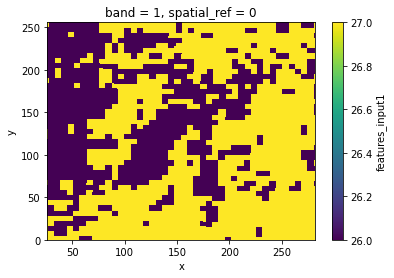

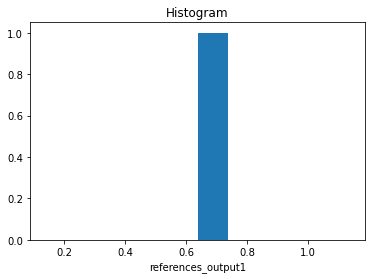

In [235]:
plot_d = aireo_lib.plotting.EOTDSPlot.plot_example(EOTDS=eo_tds_obj, 
                       ex_index=1, 
                       field_names=['features_input1', 'references_output1'])
plot_d

In [236]:
aoi_obj = eo_tds_obj.get_aoi_dataset(2)

{'features_input1': <Figure size 432x288 with 1 Axes>,
 'references_output1': <Figure size 432x288 with 1 Axes>}

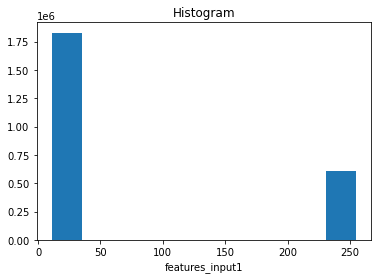

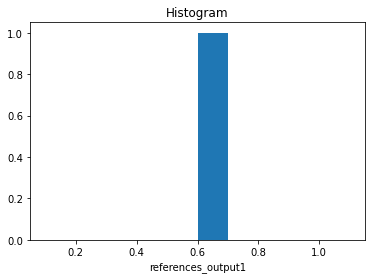

In [237]:
aoi_plots_d = aireo_lib.plotting.EOTDSPlot.plot_aoi_dataset(aoi_obj)
aoi_plots_d

### Statistics

In [238]:
import aireo_lib.statistics
from importlib import reload
reload(aireo_lib.statistics)

<module 'aireo_lib.statistics' from '/Users/adam/aireo_python_library/src/aireo_lib/statistics.py'>

In [239]:
aireo_lib.statistics.EOTDSStatistics.feature_data_statistics(eo_tds_obj)

{'aoi_0_channel_0': {'mean': 26.873867753623188,
  'std': 0.4051226901619986,
  'max': 31,
  'min': 26},
 'aoi_0_channel_1': {'mean': 19.43317777252678,
  'std': 0.6398376144134297,
  'max': 55,
  'min': 17},
 'aoi_0_channel_2': {'mean': 16.241150427956313,
  'std': 1.2698744111272524,
  'max': 52,
  'min': 11},
 'aoi_0_channel_3': {'mean': 255.0, 'std': 0.0, 'max': 255, 'min': 255},
 'aoi_1_channel_0': {'mean': 26.58989215763495,
  'std': 0.5510576821693521,
  'max': 31,
  'min': 26},
 'aoi_1_channel_1': {'mean': 18.99902856542743,
  'std': 0.6219620360048315,
  'max': 55,
  'min': 17},
 'aoi_1_channel_2': {'mean': 15.868213085486243,
  'std': 1.275843387351881,
  'max': 60,
  'min': 11},
 'aoi_1_channel_3': {'mean': 255.0, 'std': 0.0, 'max': 255, 'min': 255},
 'aoi_2_channel_0': {'mean': 26.493252467968915,
  'std': 0.6442354184800584,
  'max': 31,
  'min': 26},
 'aoi_2_channel_1': {'mean': 19.11965875078765,
  'std': 0.8970989654945212,
  'max': 51,
  'min': 17},
 'aoi_2_channel_2':

In [240]:
aireo_lib.statistics.EOTDSStatistics.reference_data_statistics(eo_tds_obj)

{'references_output1_aoi0': Counter({0.638: 1}),
 'references_output1_aoi1': Counter({0.577: 1}),
 'references_output1_aoi2': Counter({0.6: 1}),
 'references_output1_aoi3': Counter({0.635: 1}),
 'references_output1_aoi4': Counter({0.608: 1}),
 'whole_TDS_stats': {0.638: 1, 0.577: 1, 0.6: 1, 0.635: 1, 0.608: 1}}

## Format

The dataset is in spreadsheet format (.xlsx)

## Version

FOS plot data v2019.04.10

## License

This dataset is licensed under a [Creative Commons Attribution 4.0 International License (CC-BY 4.0).](https://creativecommons.org/licenses/by/4.0/)

## References

Schepaschenko, D., Chave, J., Phillips, O. L., Lewis, S. L., Davies, S. J., Réjou-Méchain, M., ... & Labrière, N. (2019). The Forest Observation System, building a global reference dataset for remote sensing of forest biomass. Scientific data, 6(1), 1-11.